In [71]:
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import time

import block_update
import bouguer
import prisms
import rfgen
import utilities

import importlib
importlib.reload(block_update)
importlib.reload(bouguer)
importlib.reload(rfgen)
importlib.reload(prisms)
importlib.reload(utilities)

from block_update import *
from bouguer import *
from rfgen import *
from prisms import *
from utilities import *

### Load BedMachine

Your dataset needs to have x and y coordinates, and bed, surface, thickness, and inv_msk data variables. Additionally, your dataset needs to have an attribute called *res* that is the spacing between your coordinates. To assign this attribute you can use:

ds.assign_attrs({'res' : 2000})

In [69]:
ds = xr.load_dataset(Path('/Users/holden/Desktop/Ice Shits/cryo_share copy/processed_data/final_bedmachine_dataset_polar_stereo.nc'))
ds

# Create 'inv_msk' in ds without renaming 'mask'
ds.attrs['inv_msk'] = ds['mask'] == 3  # Adjust the condition based on your needs

### Load gravity dataset

Your gravity dataset needs x, y, height, faa, inv_msk, and inv_pad. The inv_pad is a padding of your inversion mask. This should be about 8-12 km.

In [76]:
grav = pd.read_csv(Path('/Users/holden/Desktop/Ice Shits/cryo_share copy/processed_data/final_gravity_dataset.csv'))
grav = grav.rename(columns={'polar_stereo_x': 'x', 'polar_stereo_y': 'y'})
grav = grav.rename(columns={'measurement_height': 'height', 'faa140': 'faa'})

# Add 'inv_msk' to the gravity DataFrame 'grav'
from scipy.spatial import cKDTree

# Prepare grid coordinates and 'inv_msk' values
grid_x, grid_y = np.meshgrid(ds.x.values, ds.y.values)
grid_coords = np.column_stack((grid_x.ravel(), grid_y.ravel()))
inv_msk_values = ds['inv_msk'].values.ravel()

# Build KDTree for efficient nearest neighbor lookup
tree = cKDTree(grid_coords)

# Prepare gravity data coordinates
grav_coords = np.column_stack((grav.x.values, grav.y.values))

# Query the nearest grid point for each gravity data point
_, indices = tree.query(grav_coords, k=1)

# Assign 'inv_msk' values to gravity data points
grav['inv_msk'] = inv_msk_values[indices]

print(ds)

# make inv_pad
xx, yy = np.meshgrid(ds.x, ds.y)

inv_pad = vd.distance_mask(
    data_coordinates = (xx[ds.inv_msk==True], yy[ds.inv_msk==True]),
    coordinates = (grav.x, grav.y),
    maxdist = 10e3
)

grav['inv_pad'] = inv_pad

grav.head()

KeyError: "No variable named 'inv_msk'. Variables on the dataset include ['bed', 'surface', 'thickness', 'geoid', 'x', 'y', 'mask', 'dataid', 'source']"

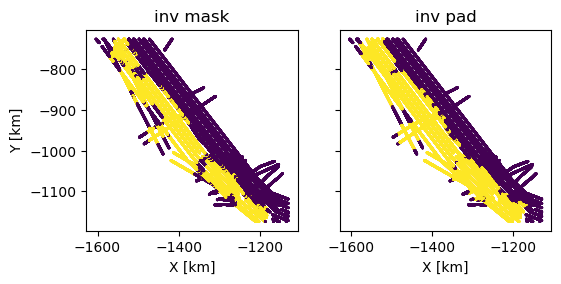

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(6,4), sharey=True)
ax = axs[0]
ax.scatter(grav.x/1000, grav.y/1000, c=grav.inv_msk, s=1)
ax.axis('scaled')
ax.set_title('inv mask')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax = axs[1]
ax.scatter(grav.x/1000, grav.y/1000, c=grav.inv_pad, s=1)
ax.axis('scaled')
ax.set_title('inv pad')
ax.set_xlabel('X [km]')
plt.show()

### Make a target terrain effect using SGS and filter

* The *nte_correction_sgs* function makes an SGS realization of the Bouguer disturbance for the given density
* The *filter_boug* function filters the Bouguer disturbance with the given cutoff distance. You can experiment with this parameter to make a target terrain effect that looks like a continuous field. The higher this value, the smoother the Bouguer disturbance will become
* The *sgs_filt* function can be used to do both of these things

In [7]:
ds.attrs['res'] = 5000

In [10]:
data = np.load('sgs_simulations.npz')

# Access the simulations
sim1 = data['sim1']
sim2 = data['sim2']
sim3 = data['sim3']

In [11]:
target = sim1

In [14]:
boug_filt = filter_boug(ds, grav, target, cutoff=12e3, pad=0)

x_valid shape: (191867,)
y_valid shape: (191867,)
faa_valid shape: (191867,)
target_valid shape: (191867,)
boug_filt_valid shape: (191867,)


In [31]:
boug_sgs = faa_grid - target_grid
new_target_grid = faa_grid - boug_filt_grid

print("boug_sgs min:", np.nanmin(boug_sgs), "max:", np.nanmax(boug_sgs))
print("target_grid min:", np.nanmin(target_grid), "max:", np.nanmax(target_grid))
print("boug_filt_grid min:", np.nanmin(boug_filt_grid), "max:", np.nanmax(boug_filt_grid))
print("new_target_grid min:", np.nanmin(new_target_grid), "max:", np.nanmax(new_target_grid))

boug_sgs min: nan max: nan
target_grid min: nan max: nan
boug_filt_grid min: nan max: nan
new_target_grid min: nan max: nan


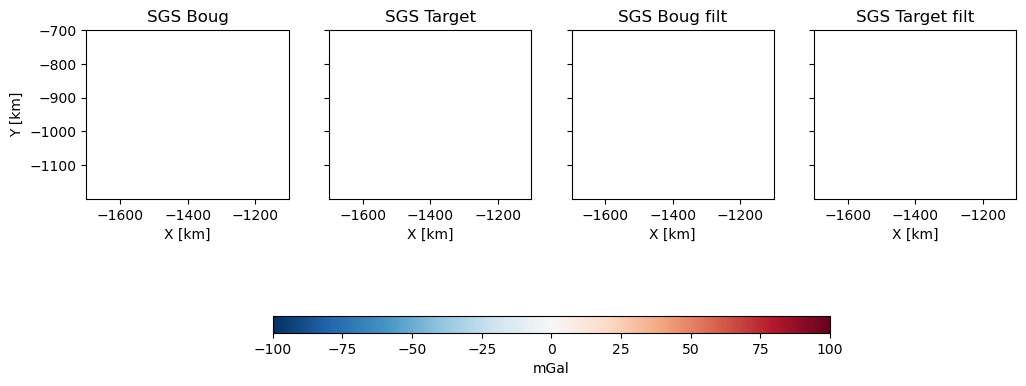

In [59]:
xkm = ds.x/1000
ykm = ds.y/1000

grav_vmin = -100
grav_vmax = 100

fig = plt.figure(figsize=(12,5))

gridspec = GridSpec(2, 4, height_ratios=[1, 0.05])

grids = [boug_sgs, target_grid, boug_filt_grid, new_target_grid]
titles = ['SGS Boug', 'SGS Target', 'SGS Boug filt', 'SGS Target filt']

axs = []
for i, (grid, title) in enumerate(zip(grids, titles)):
    ax = fig.add_subplot(gridspec[0,i])
    axs.append(ax)
    im = ax.pcolormesh(xkm, ykm, grid, vmin=grav_vmin, vmax=grav_vmax, cmap='RdBu_r')
    ax.axis('scaled')
    ax.set_title(title)
    ax.set_xlabel('X [km]')

axs[0].set_ylabel('Y [km]')

for ax in axs[1:]:
    ax.set_yticklabels([])

gs2 = GridSpecFromSubplotSpec(1, 100, gridspec[1,:])
cax = fig.add_subplot(gs2[20:80])
plt.colorbar(im, cax=cax, label='mGal', orientation='horizontal')
plt.show()

### Make a target with *sgs_filt* for inversion and get gravity inside the inv_pad

In [53]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import binned_statistic_2d
import matplotlib.gridspec as gridspec

# ======================================
# Step 1: Load and Inspect SGS Simulations
# ======================================

# Load the .npz file containing SGS simulations
simulations = np.load('sgs_simulations.npz')

# List all available keys in the .npz file
print("Available keys in 'sgs_simulations.npz':")
print(simulations.files)

# Identify the correct key for simulations
sim_key = 'sim1'  # <-- Update this key based on the output from simulations.files

if sim_key not in simulations.files:
    raise KeyError(f"'{sim_key}' is not a valid key in 'sgs_simulations.npz'. Available keys: {simulations.files}")

# Extract the simulation data
simulations_transformed = simulations[sim_key]

# Define 'sim1' based on the shape
if simulations_transformed.ndim == 2:
    sim1 = simulations_transformed  # Single simulation
elif simulations_transformed.ndim == 3:
    sim1 = simulations_transformed[0]  # First simulation
else:
    raise ValueError(f"Unexpected number of dimensions in 'simulations_transformed': {simulations_transformed.ndim}")

print("sim1 shape:", sim1.shape)
print("Grid dimensions:", len(ds['y']), len(ds['x']))

# ======================================
# Step 2: Define the sgs_filt Function
# ======================================

def filter_boug(ds, grav, target, cutoff, pad):
    """
    Implement your actual Bouguer filtering logic here.
    This is a placeholder function and should be replaced with your real implementation.
    """
    # Placeholder: Apply some filtering to 'target'
    # Ensure that the returned 'boug_filt' has shape (ny, nx)
    
    # Example: Simple low-pass Gaussian filter (replace with actual logic)
    from scipy.ndimage import gaussian_filter
    
    boug_filt = gaussian_filter(target, sigma=pad)  # Adjust sigma as needed
    
    return boug_filt  # Should have shape (ny, nx)

def sgs_filt(ds, grav, density, cutoff, pad, sim1):
    """
    Filters the Bouguer gravity data based on SGS simulation.

    Parameters:
    - ds: xarray Dataset containing grid information.
    - grav: pandas DataFrame containing gravity observations.
    - density: Density value used in calculations.
    - cutoff: Cutoff frequency for filtering.
    - pad: Padding parameter.
    - sim1: SGS simulation data as a 2D NumPy array.

    Returns:
    - new_target: The result of subtracting the interpolated Bouguer filter from the observed gravity data.
                  Shape: (n_observations,)
    """
    # Apply the filter_boug function to the simulation grid
    boug_filt = filter_boug(ds, grav, sim1, cutoff, pad)
    print("boug_filt shape after filter_boug:", boug_filt.shape)
    
    # If boug_filt is 1D, reshape to (ny, nx)
    if boug_filt.ndim == 1:
        ny = len(ds['y'])
        nx = len(ds['x'])
        if boug_filt.size != ny * nx:
            raise ValueError(f"Expected boug_filt size {ny * nx}, but got {boug_filt.size}")
        boug_filt = boug_filt.reshape((ny, nx))
        print("Reshaped boug_filt to:", boug_filt.shape)
    
    # Prepare grid coordinates
    x_grid = ds['x'].values  # Shape: (nx,)
    y_grid = ds['y'].values  # Shape: (ny,)
    
    # Ensure grid coordinates are sorted in ascending order
    x_sorted_indices = np.argsort(x_grid)
    y_sorted_indices = np.argsort(y_grid)
    x_grid_sorted = x_grid[x_sorted_indices]
    y_grid_sorted = y_grid[y_sorted_indices]
    
    # Sort boug_filt accordingly
    boug_filt_sorted = boug_filt[y_sorted_indices, :][:, x_sorted_indices]
    print("boug_filt_sorted shape:", boug_filt_sorted.shape)
    
    # Create interpolator for boug_filt
    interpolator_boug_filt = RegularGridInterpolator(
        (y_grid_sorted, x_grid_sorted),
        boug_filt_sorted,
        bounds_error=False,
        fill_value=np.nan
    )
    
    # Prepare observation points
    x_obs = grav['x'].values  # Shape: (191867,)
    y_obs = grav['y'].values  # Shape: (191867,)
    points = np.column_stack((y_obs, x_obs))  # Shape: (191867, 2)
    
    print("Interpolate boug_filt to observation points...")
    
    # Interpolate boug_filt to observation points
    boug_filt_at_obs = interpolator_boug_filt(points)  # Shape: (191867,)
    print("boug_filt_at_obs shape:", boug_filt_at_obs.shape)
    
    # Check if boug_filt_at_obs has the same shape as grav.faa.values
    if boug_filt_at_obs.shape != grav.faa.values.shape:
        raise ValueError(f"After interpolation, boug_filt_at_obs shape {boug_filt_at_obs.shape} does not match grav.faa.values shape {grav.faa.values.shape}")
    
    # Compute new_target
    new_target = grav.faa.values - boug_filt_at_obs  # Shape: (191867,)
    print("new_target shape:", new_target.shape)
    
    return new_target


# Trim gravity data
grav_mskd = grav[grav.inv_pad == True]

Available keys in 'sgs_simulations.npz':
['sim1', 'sim2', 'sim3']
sim1 shape: (100, 120)
Grid dimensions: 100 120


### Make random field for initial condition

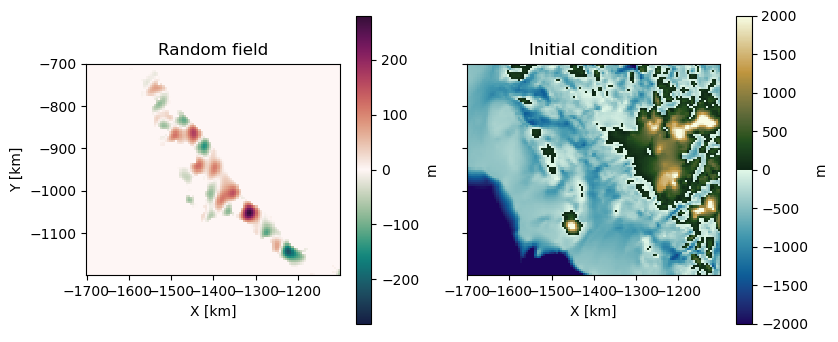

In [51]:
# make arrays for random field generation
range_max = [50e3, 50e3]
range_min = [30e3, 30e3]
high_step = 300
nug_max = 0.0
eps = 3e-4

rfgen = RFGen(ds, range_max, range_min, high_step, nug_max, eps, 'Gaussian')
field = rfgen.generate_field(condition=True)

x0 = ds.bed.data + field
x0 = np.where(x0>ds.surface-ds.thickness, ds.surface-ds.thickness, x0)

vmax = np.max(np.abs(field))

fig, axs = plt.subplots(1, 2, figsize=(9,4), sharey=True)
ax = axs[0]
im = ax.pcolormesh(xkm, ykm, field, vmax=vmax, vmin=-vmax, cmap='cmo.curl')
ax.axis('scaled')
ax.set_title('Random field')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
plt.colorbar(im, ax=ax, label='m')

topo_cm = get_topo_cm()

ax = axs[1]
im = ax.pcolormesh(xkm, ykm, x0, vmax=2000, vmin=-2000, cmap=topo_cm)
ax.axis('scaled')
ax.set_title('Initial condition')
ax.set_xlabel('X [km]')
plt.colorbar(im, ax=ax, label='m')

plt.show()

### Make prism generator and observation coordinates

In [74]:
density_dict = {
    'ice' : 917,
    'water' : 1027,
    'rock' : 2670
}
pgen = PrismGen(density_dict)

pred_coords = (grav_mskd.x.values, grav_mskd.y.values, grav_mskd.height.values)

In [75]:
pred_coords[0].shape, target.shape

((97299,), (100, 120))

### Set parameters for inversion and run the inversion

* You will want to tune the block parameter sequence to make the inversion
* The sigma gravity uncertainty comes from crossover errors in my data. You can use this or change it if you have information about the uncertainty of your gravity data. This will change how likely the MCMC is to accept changes that make the error worse.
* The stopping criterion stops the inversion once the RMSE reaches a certain point. You will want to experiment to find a value that your inversion can reach in a reasonable amount of time. Note that you don't really want to push this to find the lowest value that you can reach. The inversion will overfit the data as it continues.

In [73]:
ds.attrs['inv_msk'] = ds['mask'] == 3
ds.attrs['res'] = 5000

# Define your inversion parameters
sequence = [
    [21, 20, 60, 1000],
    [15, 20, 40, 1000],
    [9, 5, 40, 5000],
    [5, 5, 40, 40000]
]

# Gravity uncertainty
sigma = 1.6

# RMSE stopping condition
stop = 1

# Get random number generator
rng = np.random.default_rng(seed=0)

# Run chain sequence and time it
tic = time.time()
result = chain_sequence(sequence, ds, x0, pred_coords, target, sigma, pgen, rng, stop=stop)
toc = time.time()
print(f'total time: {toc - tic:.1f} seconds')

  0%|                                                   | 0/999 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (21,21) (100,120) 

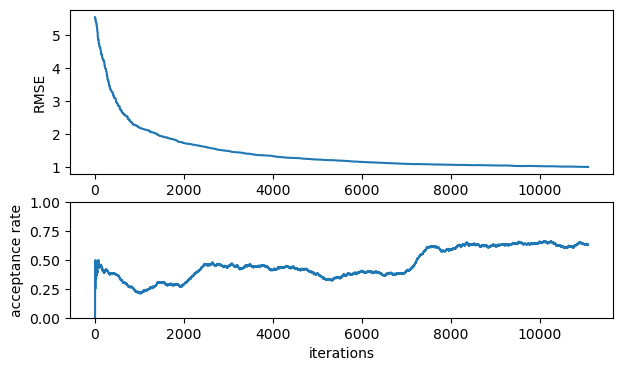

In [16]:
from diagnostics import run_acceptance_rate

rmse = np.sqrt(result['loss_cache']/target.size)

fig, axs = plt.subplots(2, 1, figsize=(7,4), gridspec_kw=dict(height_ratios=[1,0.7]))
ax = axs[0]
ax.plot(rmse)
ax.set_ylabel('RMSE')

# running acceptance rate with a 500 iteration window
run_acc = run_acceptance_rate(result['step_cache'], 500, 0)

ax = axs[1]
ax.plot(run_acc)
ax.set_xlabel('iterations')
ax.set_ylabel('acceptance rate')
ax.set_ylim(0, 1)
plt.show()

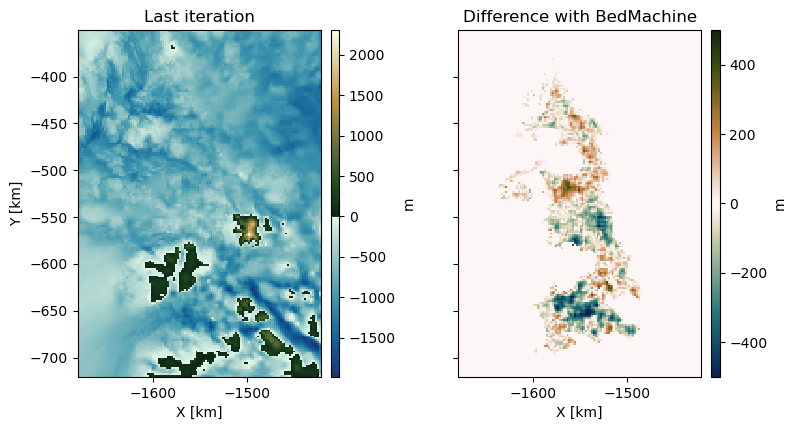

In [17]:
import cmocean
from utilities import get_topo_cm

bed = result['bed_cache']

topo_cmap = get_topo_cm()
topo_crop = cmocean.tools.crop(topo_cmap, np.min(bed), np.max(bed), 0)
vmin_topo = np.min(bed); vmax_topo = np.max(bed)

fig, axs = plt.subplots(1, 2, figsize=(9,4.5), sharey=True)

# plot last bed iteration
ax = axs[0]
im = ax.pcolormesh(xkm, ykm, bed, vmin=vmin_topo, vmax=vmax_topo, cmap=topo_crop)
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_title('Last iteration')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')

# plot difference from BedMachine
ax = axs[1]
im = ax.pcolormesh(xkm, ykm, ds.bed_no_muto-bed, vmin=-500, vmax=500, cmap='cmo.tarn_r')
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_title('Difference with BedMachine')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')
plt.show()

### Let's look at the gravity residual at the end

In [18]:
target_grid, grav_result_grid = xy_into_grid(ds, (pred_coords[0], pred_coords[1]), 
                                             (target, result['grav_cache']))

residual_grid = target_grid - grav_result_grid

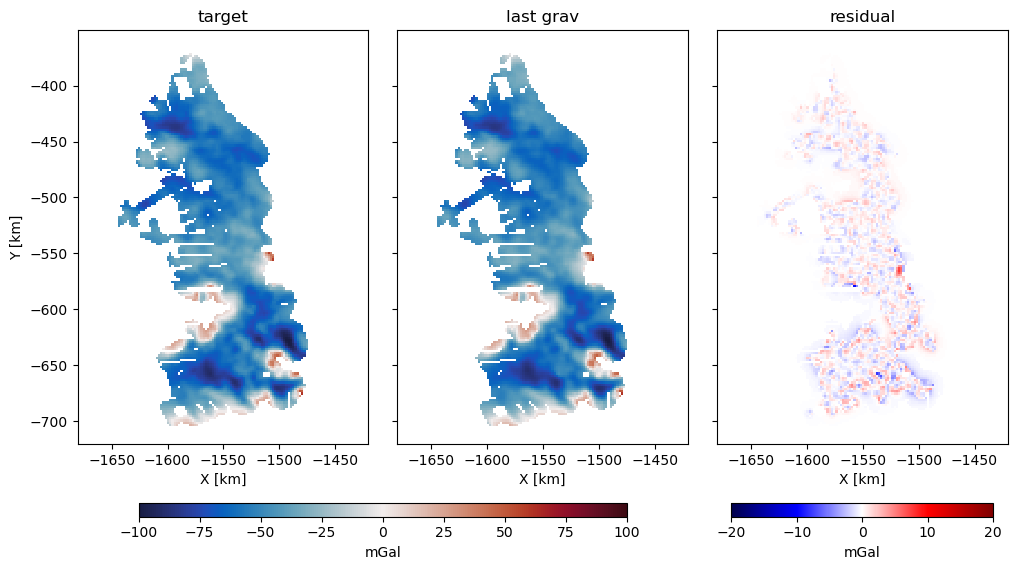

In [19]:
#fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)

fig = plt.figure(figsize=(12,6.5))
gridspec = GridSpec(2, 3, height_ratios=[1, 0.03], wspace=0.1)

ax1 = fig.add_subplot(gridspec[0,0])
ax2 = fig.add_subplot(gridspec[0,1])
ax3 = fig.add_subplot(gridspec[0,2])

ax = ax1
im = ax.pcolormesh(xkm, ykm, target_grid, vmin=-100, vmax=100, cmap='cmo.balance')
ax.axis('scaled')
ax.set_title('target')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')

ax = ax2
im = ax.pcolormesh(xkm, ykm, grav_result_grid, vmin=-100, vmax=100, cmap='cmo.balance')
ax.axis('scaled')
ax.set_title('last grav')
ax.set_xlabel('X [km]')
ax.set_yticklabels([])

gs2 = GridSpecFromSubplotSpec(1, 100, gridspec[1,:2])
cax = fig.add_subplot(gs2[10:90])
plt.colorbar(im, cax=cax, label='mGal', orientation='horizontal')

ax = ax3
im = ax.pcolormesh(xkm, ykm, residual_grid, vmin=-20, vmax=20, cmap='seismic')
ax.axis('scaled')
ax.set_title('residual')
ax.set_xlabel('X [km]')
ax.set_yticklabels([])

gs3 = GridSpecFromSubplotSpec(1, 100, gridspec[1,2])
cax = fig.add_subplot(gs3[5:95])
plt.colorbar(im, cax=cax, label='mGal', orientation='horizontal')
plt.show()

### Filter the final bed iteration

The inversion process can create some edge artifacts because of the blocks. Let's use a lowpass Gaussian filter to smooth it out a little. You can change the cutoff to change how much smoothing there is.

In [20]:
bed_filt = lowpass_filter_domain(ds, bed, np.ones(bed.shape), cutoff=5e3, pad=0)
bed_filt = bed_filt.reshape(bed.shape)
bed_high = bed-bed_filt

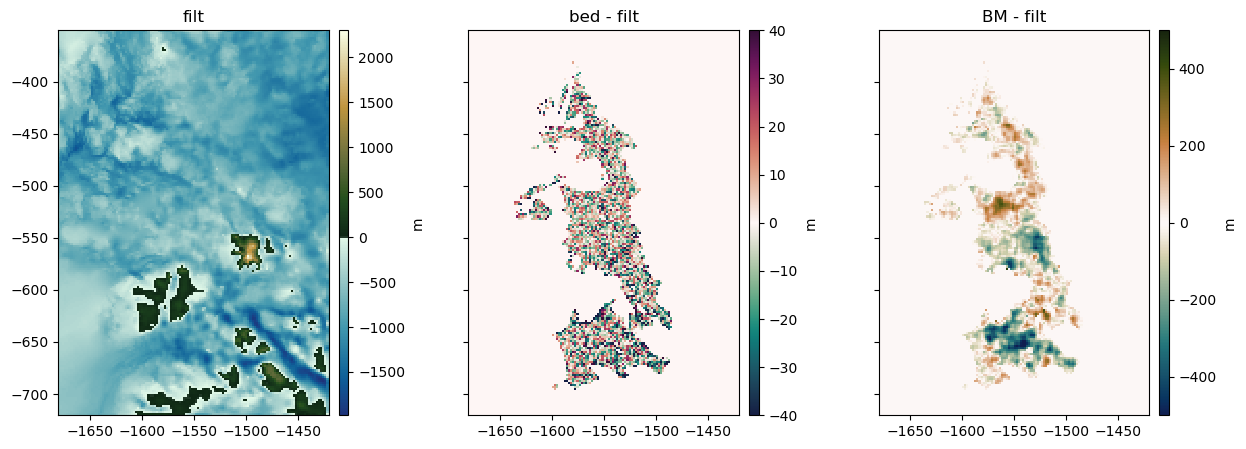

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)
ax = axs[0]
im = ax.pcolormesh(xkm, ykm, bed_filt, vmin=vmin_topo, vmax=vmax_topo, cmap=topo_crop)
ax.axis('scaled')
ax.set_title('filt')
plt.colorbar(im, pad=0.03, aspect=40, ax=ax, label='m')

ax = axs[1]
im = ax.pcolormesh(xkm, ykm, bed-bed_filt, vmin=-40, vmax=40, cmap='cmo.curl')
ax.axis('scaled')
ax.set_title('bed - filt')
plt.colorbar(im, pad=0.03, aspect=40, ax=ax, label='m')

ax = axs[2]
im = ax.pcolormesh(xkm, ykm, ds.bed_no_muto-bed_filt, vmin=-500, vmax=500, cmap='cmo.tarn_r')
ax.axis('scaled')
ax.set_title('BM - filt')
plt.colorbar(im, pad=0.03, aspect=40, ax=ax, label='m')
plt.show()

### We can look at the high frequency and see that it has linear edges in it

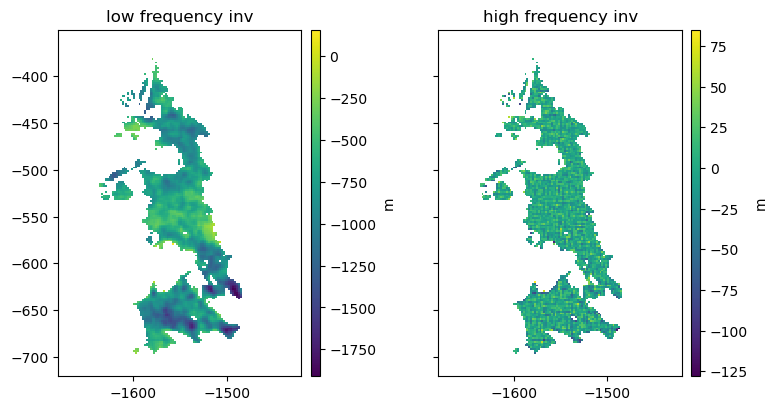

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(9,4.5), sharey=True)

ax = axs[0]
im = ax.pcolormesh(xkm, ykm, np.where(ds.inv_msk, bed_filt, np.nan))
ax.axis('scaled')
ax.set_title('low frequency inv')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')

ax = axs[1]
im = ax.pcolormesh(xkm, ykm, np.where(ds.inv_msk, bed_high, np.nan))
ax.axis('scaled')
ax.set_title('high frequency inv')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')
plt.show()

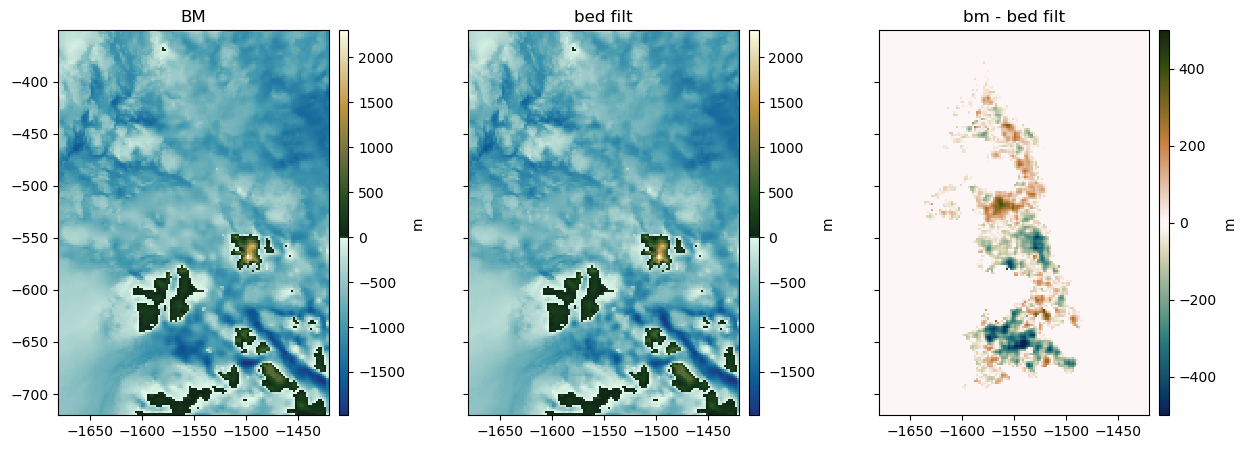

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)
ax = axs[0]
im = ax.pcolormesh(xkm, ykm, ds.bed_no_muto, vmin=vmin_topo, vmax=vmax_topo, cmap=topo_crop)
ax.axis('scaled')
ax.set_title('BM')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')

ax = axs[1]
im = ax.pcolormesh(xkm, ykm, bed_filt, vmin=vmin_topo, vmax=vmax_topo, cmap=topo_crop)
ax.axis('scaled')
ax.set_title('bed filt')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')

ax = axs[2]
im = ax.pcolormesh(xkm, ykm, ds.bed_no_muto-bed_filt, vmin=-500, vmax=500, cmap='cmo.tarn_r')
ax.axis('scaled')
ax.set_title('bm - bed filt')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')
plt.show()

## Conditioning on boundary of inversion domain

* These are weights that will be applied to updates to prevent dramatic changes on the inversion domain boundary.
* These functions can be used to make weights using a logistic function
* You can test out different parameters to the logistic function to make different weights
* Having low weights near the conditioning data will make it take longer to lower the RMSE

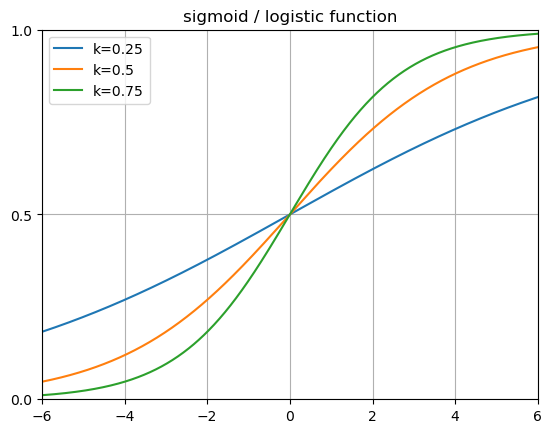

In [24]:
import matplotlib.ticker as plticker

tmp = np.linspace(-6, 6, 1000)

fig, ax = plt.subplots()

for k in [0.25, 0.5, 0.75]:
    ax.plot(tmp, logistic(tmp, 1, 0, k), label=f'k={str(k)}')
    
intervals = 0.5
loc = plticker.MultipleLocator(base=intervals)
ax.yaxis.set_major_locator(loc)
intervals = 2
loc = plticker.MultipleLocator(base=intervals)
ax.xaxis.set_major_locator(loc)
ax.grid(which='major', axis='both', linestyle='-')
ax.set_ylim(0, 1.0)
ax.set_xlim(-6, 6)
ax.set_title('sigmoid / logistic function')
ax.legend()
plt.show()

### Test out parameters to apply to the rescaled distance from conditioning data

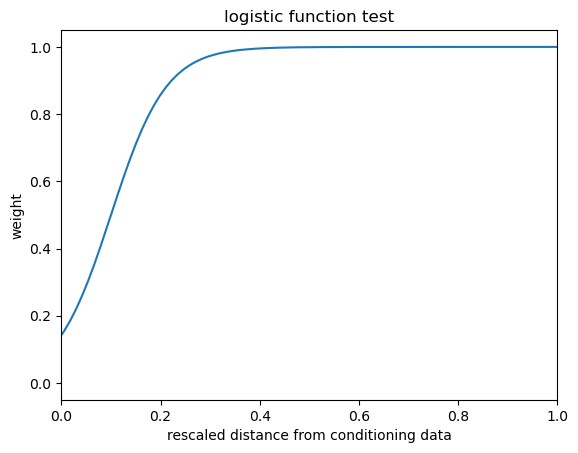

In [33]:
plt.plot(tmp, logistic(tmp, 1, 0.1, 18))
plt.xlim(0, 1)
plt.xlabel('rescaled distance from conditioning data')
plt.ylabel('weight')
plt.title('logistic function test')
plt.show()

In [26]:
xx, yy = np.meshgrid(ds.x, ds.y)
min_dist_l2 = min_dist_simple(ds.inv_msk.values, xx, yy)

dist_scale = rescale(min_dist_l2)
#dist_logi = logistic(dist_scale, 1, 0.3, 12)
dist_logi = logistic(dist_scale, 1, 0.05, 18)
dist_logi = np.where(ds.inv_msk==False, 0, dist_logi)

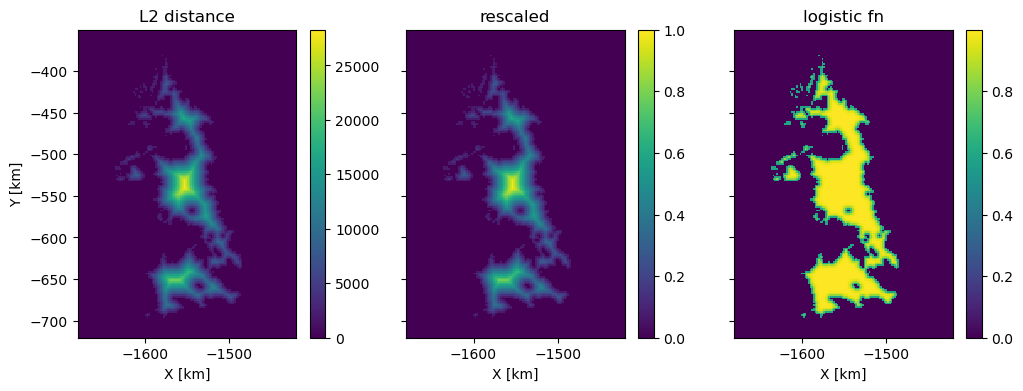

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(12,4), sharey=True)
ax = axs[0]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, min_dist_l2)
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_title('L2 distance')
plt.colorbar(im, ax=ax)

ax = axs[1]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, dist_scale)
ax.set_xlabel('X [km]')
ax.set_title('rescaled')
plt.colorbar(im, ax=ax)

ax = axs[2]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, dist_logi)
ax.set_xlabel('X [km]')
ax.set_title('logistic fn')
plt.colorbar(im, ax=ax)

plt.show()

### Run inversion with conditioning weights

In [28]:
x0 = ds.bed.data + field
x0 = np.where(x0>ds.surface-ds.thickness, ds.surface-ds.thickness, x0)

rng = np.random.default_rng(seed=0)

tic = time.time()
result = chain_sequence(sequence, ds, x0, pred_coords, target, sigma, pgen, rng, dist_logi, stop=stop)
toc = time.time()
print(f'total time: {toc-tic:.1f}')

  0%|          | 0/1000 [00:00<?, ?it/s]

chain 0 efficiency: -0.095 RMSE/sec


  0%|          | 0/1000 [00:00<?, ?it/s]

chain 1 efficiency: -0.019 RMSE/sec


  0%|          | 0/5000 [00:00<?, ?it/s]

chain 2 efficiency: -0.011 RMSE/sec


  0%|          | 0/40000 [00:00<?, ?it/s]

chain 3 efficiency: -0.002 RMSE/sec
0 finished
total time: 200.8


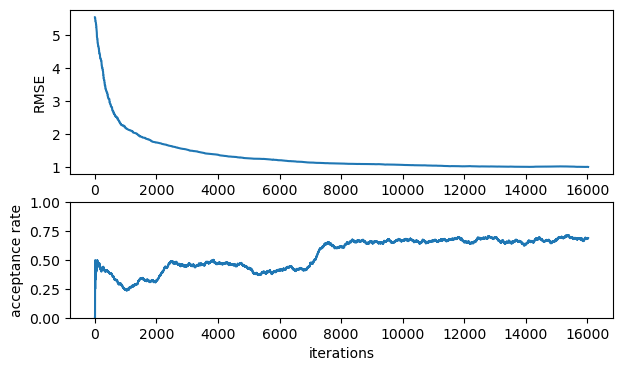

In [29]:
rmse = np.sqrt(result['loss_cache']/target.size)

fig, axs = plt.subplots(2, 1, figsize=(7,4), gridspec_kw=dict(height_ratios=[1,0.7]))
ax = axs[0]
ax.plot(rmse)
ax.set_ylabel('RMSE')

# running acceptance rate with a 500 iteration window
run_acc = run_acceptance_rate(result['step_cache'], 500, 0)

ax = axs[1]
ax.plot(run_acc)
ax.set_xlabel('iterations')
ax.set_ylabel('acceptance rate')
ax.set_ylim(0, 1)
plt.show()

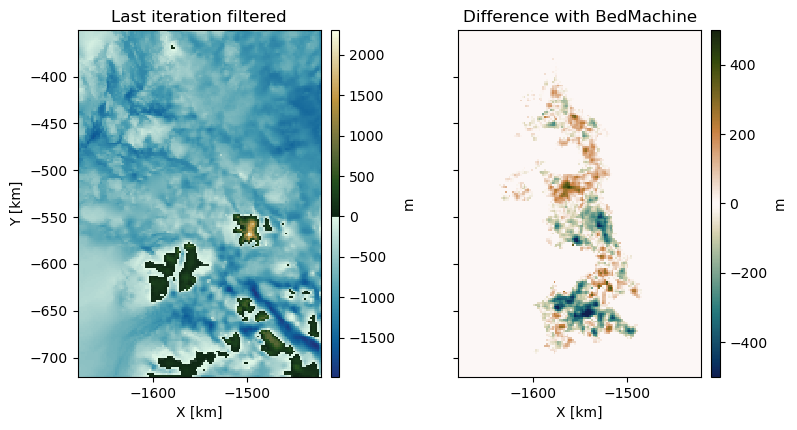

In [30]:
bed = result['bed_cache']

bed_filt = lowpass_filter_domain(ds, bed, np.ones(bed.shape), cutoff=5e3, pad=0)
bed_filt = bed_filt.reshape(bed.shape)

topo_cmap = get_topo_cm()
topo_crop = cmocean.tools.crop(topo_cmap, np.min(bed), np.max(bed), 0)
vmin_topo = np.min(bed); vmax_topo = np.max(bed)

fig, axs = plt.subplots(1, 2, figsize=(9,4.5), sharey=True)

# plot last bed iteration
ax = axs[0]
im = ax.pcolormesh(xkm, ykm, bed_filt, vmin=vmin_topo, vmax=vmax_topo, cmap=topo_crop)
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_title('Last iteration filtered')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')

# plot difference from BedMachine
ax = axs[1]
im = ax.pcolormesh(xkm, ykm, ds.bed_no_muto-bed_filt, vmin=-500, vmax=500, cmap='cmo.tarn_r')
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_title('Difference with BedMachine')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')
plt.show()